In [2]:
import rasterio
import rasterio.plot
from rasterio.plot import reshape_as_raster, reshape_as_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Read Dataset

In [7]:
import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

class VisionDataset(Dataset):

    def __init__(self, img_dir, channel=None, transform=None):
        """
        Args:
            img_dir(string): Path to the csv file with paths to image files.
            channel (string): Number of channel to read (either RGB channel or All/Multispectral).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img = pd.read_csv(img_dir)
        self.channel = channel
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = self.img.iloc[idx,0]
        segimg_file = self.img.iloc[idx,1]
        
        img_raster = rasterio.open(img_file) #open a file with .tif extension using restario
        segimg_raster = rasterio.open(segimg_file)
        norm_img = self.norm_image(img_raster, self.channel)     
        img_raster.close()

        seg_img = segimg_raster.read()
        if np.max(seg_img) == 255: #there is apparently a segmented image with values of 255 which are beyond the number of classes  
            seg_img[seg_img==255] = 1
        segimg_raster.close()
        
        if self.transform:
            np.random.seed(1)
            n = np.random.randint(0,3)
            if n != 0:
                norm_img  = torch.tensor(norm_img).flip(n)
                seg_img = torch.tensor(seg_img).flip(n)
                
        sample = {'image': np.array(norm_img), 'label': np.array(seg_img)}
        return sample
    
    def norm_image(self, src, channel):
        if channel == 'RGB':
            idx = [4,3,2]
        else:
            idx = channel

        data = src.read(idx)

        return rasterio.plot.adjust_band(data, kind='linear')
        
    def open_as_image(self, instance):
        if torch.is_tensor(instance):
            instance = instance.detach().numpy()

        if instance.shape[0] > 3:
            new_instance = np.dstack((instance[3],instance[2],instance[1]))
            return plt.imshow(new_instance)
        elif instance.shape[0] == 3:
            return plt.imshow(reshape_as_image(instance))
        else:
            return plt.imshow(instance[0])
            
    def open_segmented_image(self, image):
        if torch.is_tensor(image):
            image = image.detach().numpy()
            
        if image.shape[0] == 3:
            image = image.argmax(0) #find the class using argmax across the channels
            return plt.imshow(image)
        else:
            return plt.imshow(image[0])
            

In [291]:
# Define transforms
transformer = transforms.Compose([
        transforms.ToTensor()
    ])


def create_dataloader(dataset,batch_size, shuffle_dataset = False):
    # Creating data indices for training and validation splits:
    #batch_size = 16
    train_test_split = .8
    #shuffle_dataset = True
    random_seed= 1

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(train_test_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices_temp, test_indices = indices[:split], indices[split:]
    train_size = len(train_indices_temp)
    val_indices = list(range(train_size))
    split_val = int(np.floor(train_test_split * train_size))
    train_indices, val_indices = val_indices[:split_val], val_indices[split_val:]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)
    
    return train_loader,test_loader,val_loader

# Define custom dataset
dataset = VisionDataset(img_dir='vision_img.csv',transform=transformer)
rgb_dataset = VisionDataset(img_dir='vision_img.csv',channel='RGB',transform=transformer)
train_loader,test_loader,val_loader = create_dataloader(dataset, batch_size=16, shuffle_dataset=True)
train_loader_rgb,test_loader_rgb,val_loader_rgb = create_dataloader(rgb_dataset, batch_size=16, shuffle_dataset=True)
    

In [292]:
print('Train size : {}'.format(len(train_loader)))
print('Validation size : {}'.format(len(val_loader)))
print('Test size : {}'.format(len(test_loader)))

Train size : 228
Validation size : 57
Test size : 72


In [337]:
def plot_img(test_dataloader,model,n):
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    np.random.seed(1)
    test_data = next(iter(test_dataloader))
    
    model.to(device)
    y_hat = model(test_data['image'].to(device))
    
    if n>len(test_dataloader):
        n = len(test_dataloader)
        
    for j in range(n):
        plt.figure(figsize = (10, 8))
        plt.subplot(j+1,3,1)
        dataset.open_as_image(test_data['image'][j])
        plt.title('Pre-processed Original Image')
        plt.axis('off')

        plt.subplot(j+1,3,2)
        dataset.open_segmented_image(test_data['label'][j])
        plt.title('Original Segmented Image')
        plt.axis('off')

        plt.subplot(j+1,3,3)
        dataset.open_segmented_image(y_hat[j].cpu())
        plt.title('Predicted Segmented Image')
        plt.axis('off')

In [331]:
#load training dataset for multispectral images
loader = next(iter(train_loader))
print('Multispectral Dataset')
print('Batch Image shape: '+ str(loader['image'].shape))
print('Batch Label shape: '+ str(loader['label'].shape))

Multispectral Dataset
Batch Image shape: torch.Size([16, 12, 64, 64])
Batch Label shape: torch.Size([16, 1, 64, 64])


In [332]:
#load training dataset for rgb only channels 
loader_rgb = next(iter(train_loader_rgb))
print('RGB Dataset')
print('Batch Image shape: '+ str(loader_rgb['image'].shape))
print('Batch Label shape: '+ str(loader_rgb['label'].shape))

RGB Dataset
Batch Image shape: torch.Size([16, 3, 64, 64])
Batch Label shape: torch.Size([16, 1, 64, 64])


In [324]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 16, 3, 1)
        self.conv2 = self.contract_block(16, 32, 3, 1)
        self.conv3 = self.contract_block(32, 64, 3, 1)

        self.upconv3 = self.expand_block(64, 32, 3, 1)
        self.upconv2 = self.expand_block(32*2, 16, 3, 1)
        self.upconv1 = self.expand_block(16*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        x = x.float()
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [326]:
#create dummy model
unet_ = UNET(12,3)
unet_

UNET(
  (conv1): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kerne

Visualizing Prediction on Multispectral Images using Untrained Model


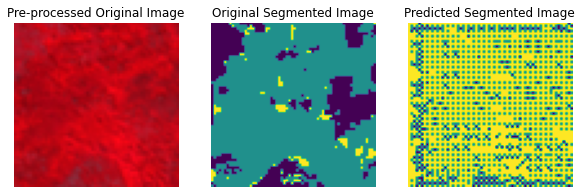

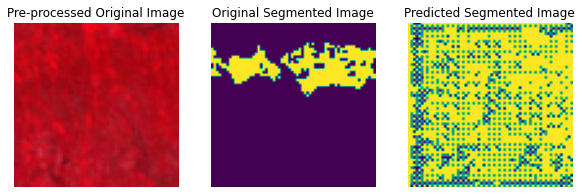

In [338]:
print('Visualizing Prediction on Multispectral Images using Untrained Model')
plot_img(train_loader,unet_,2)

Visualizing Prediction on RGB Images using Untrained Model


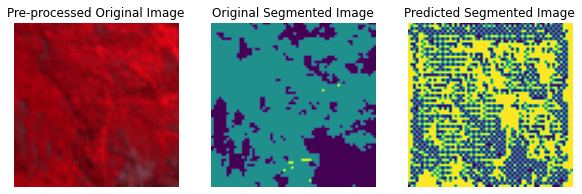

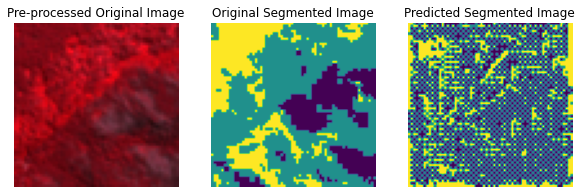

In [339]:
#create dummy model for rgb images input
unet_rgb_ = UNET(3,3)
print('Visualizing Prediction on RGB Images using Untrained Model')
plot_img(train_loader_rgb,unet_rgb_,2)

In [214]:
import time
from tqdm import tqdm

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs):
    start = time.time()
    
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0
    #model.train(True)  # Set trainind mode = true
    dataloader = train_dl
    val_loader = valid_dl
    
    print('Training')
    print('=' * 60)
    model.train()
    
    for epoch in range(1,epochs+1):
        loss_temp = 0.0
        acc_temp = 0.0

        with tqdm(dataloader, unit="batch") as tepoch:
            # iterate over data
            #for data in dataloader:
            tepoch.set_description("Epoch {}/{}".format(epoch,epochs-1))
            for data in tepoch:
                x = data['image'].to(device)
                y = data['label'].to(device)
                y = torch.squeeze(y,1)
                
                # forward pass
                outputs = model(x)

                # compute loss
                loss = loss_fn(outputs, y.long())

                # zero the gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #compute the accuracy
                acc = acc_fn(outputs, y)

                acc_temp  += acc
                loss_temp += loss 

                tepoch.set_postfix(loss=loss.item(), accuracy=100. * acc.item())
   

        running_loss = loss_temp / len(dataloader)
        running_acc = acc_temp / len(dataloader)
        print('Epoch {} Loss: {:.4f} Acc: {}'.format(epoch, running_loss, running_acc))

        print('Validation Step')
        print('=' * 60)

        val_loss = 0
        val_acc = 0
                
        for val_data in val_loader:
            x_val = val_data['image'].to(device)
            y_val = val_data['label'].to(device)
            y_val = torch.squeeze(y_val,1)

            # forward pass
            val_outputs = model(x_val)
            with torch.no_grad():
                # compute loss
                val_loss_temp = loss_fn(val_outputs, y_val.long())
                val_acc_temp = acc_fn(val_outputs, y_val)

                val_loss += val_loss_temp
                val_acc += val_acc_temp

        val_loss = val_loss/len(val_loader)
        val_acc = val_acc/len(val_loader)

        print('Validation Loss: {}  Validation Acc: {}'.format(val_loss, val_acc))
        train_loss.append(running_loss) 
        valid_loss.append(val_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

## Training on Multispectral Images

In [215]:
unet = UNET(12,3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_loader, val_loader, loss_fn, optimizer, acc_metric, epochs = 40)

Epoch 0/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Training


Epoch 0/39: 100%|██████████████████████████████████████| 228/228 [01:18<00:00,  2.91batch/s, accuracy=67.1, loss=0.903]


Epoch 0 Loss: 0.5799 Acc: 0.7584633231163025
Validation Step


Epoch 1/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 1.1195449829101562  Validation Acc: 0.5403199195861816


Epoch 1/39: 100%|██████████████████████████████████████| 228/228 [02:17<00:00,  1.66batch/s, accuracy=80.7, loss=0.492]


Epoch 1 Loss: 0.4768 Acc: 0.8123824000358582
Validation Step


Epoch 2/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9952821135520935  Validation Acc: 0.644541323184967


Epoch 2/39: 100%|██████████████████████████████████████| 228/228 [02:16<00:00,  1.67batch/s, accuracy=86.3, loss=0.346]


Epoch 2 Loss: 0.4272 Acc: 0.8341289758682251
Validation Step


Epoch 3/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9591318964958191  Validation Acc: 0.6619298458099365


Epoch 3/39: 100%|██████████████████████████████████████| 228/228 [02:13<00:00,  1.71batch/s, accuracy=79.9, loss=0.544]


Epoch 3 Loss: 0.4092 Acc: 0.836819052696228
Validation Step


Epoch 4/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 1.0274397134780884  Validation Acc: 0.6212275624275208


Epoch 4/39: 100%|██████████████████████████████████████| 228/228 [02:05<00:00,  1.81batch/s, accuracy=78.7, loss=0.522]


Epoch 4 Loss: 0.3968 Acc: 0.8399343490600586
Validation Step


Epoch 5/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9585405588150024  Validation Acc: 0.654516875743866


Epoch 5/39: 100%|██████████████████████████████████████| 228/228 [01:58<00:00,  1.92batch/s, accuracy=90.8, loss=0.241]


Epoch 5 Loss: 0.3840 Acc: 0.846575140953064
Validation Step


Epoch 6/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.908687174320221  Validation Acc: 0.663762092590332


Epoch 6/39: 100%|███████████████████████████████████████| 228/228 [02:02<00:00,  1.86batch/s, accuracy=82.8, loss=0.49]


Epoch 6 Loss: 0.3778 Acc: 0.8497644662857056
Validation Step


Epoch 7/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8820611238479614  Validation Acc: 0.6640318036079407


Epoch 7/39: 100%|███████████████████████████████████████| 228/228 [01:57<00:00,  1.94batch/s, accuracy=79.2, loss=0.44]


Epoch 7 Loss: 0.3528 Acc: 0.8591122627258301
Validation Step


Epoch 8/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 1.0171265602111816  Validation Acc: 0.6504749059677124


Epoch 8/39: 100%|██████████████████████████████████████| 228/228 [01:53<00:00,  2.02batch/s, accuracy=65.4, loss=0.972]


Epoch 8 Loss: 0.3559 Acc: 0.858371913433075
Validation Step


Epoch 9/39:   0%|                                                                           | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9617028832435608  Validation Acc: 0.6539937257766724


Epoch 9/39: 100%|██████████████████████████████████████| 228/228 [02:13<00:00,  1.71batch/s, accuracy=85.4, loss=0.384]


Epoch 9 Loss: 0.3490 Acc: 0.8592402338981628
Validation Step


Epoch 10/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8174719214439392  Validation Acc: 0.6911327242851257


Epoch 10/39: 100%|██████████████████████████████████████| 228/228 [01:58<00:00,  1.92batch/s, accuracy=89.1, loss=0.29]


Epoch 10 Loss: 0.3450 Acc: 0.86201012134552
Validation Step


Epoch 11/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8951663970947266  Validation Acc: 0.6678656339645386


Epoch 11/39: 100%|██████████████████████████████████████| 228/228 [02:01<00:00,  1.88batch/s, accuracy=59.5, loss=1.38]


Epoch 11 Loss: 0.3457 Acc: 0.8615870475769043
Validation Step


Epoch 12/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8454059958457947  Validation Acc: 0.6874378323554993


Epoch 12/39: 100%|█████████████████████████████████████| 228/228 [02:10<00:00,  1.75batch/s, accuracy=83.2, loss=0.395]


Epoch 12 Loss: 0.3372 Acc: 0.8644071817398071
Validation Step


Epoch 13/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8884483575820923  Validation Acc: 0.6842817664146423


Epoch 13/39: 100%|█████████████████████████████████████| 228/228 [02:04<00:00,  1.83batch/s, accuracy=77.3, loss=0.635]


Epoch 13 Loss: 0.3317 Acc: 0.8679907321929932
Validation Step


Epoch 14/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8009253740310669  Validation Acc: 0.6917557120323181


Epoch 14/39: 100%|██████████████████████████████████████| 228/228 [01:53<00:00,  2.01batch/s, accuracy=68.6, loss=0.71]


Epoch 14 Loss: 0.3218 Acc: 0.8708360195159912
Validation Step


Epoch 15/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8021073937416077  Validation Acc: 0.6813440322875977


Epoch 15/39: 100%|█████████████████████████████████████| 228/228 [01:59<00:00,  1.91batch/s, accuracy=92.8, loss=0.212]


Epoch 15 Loss: 0.3273 Acc: 0.8694294691085815
Validation Step


Epoch 16/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7793617844581604  Validation Acc: 0.7118885517120361


Epoch 16/39: 100%|█████████████████████████████████████| 228/228 [02:00<00:00,  1.89batch/s, accuracy=92.6, loss=0.219]


Epoch 16 Loss: 0.3221 Acc: 0.871496856212616
Validation Step


Epoch 17/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7921292781829834  Validation Acc: 0.7005115151405334


Epoch 17/39: 100%|████████████████████████████████████████| 228/228 [01:57<00:00,  1.94batch/s, accuracy=97, loss=0.12]


Epoch 17 Loss: 0.3129 Acc: 0.8748822212219238
Validation Step


Epoch 18/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 1.068587303161621  Validation Acc: 0.6503416895866394


Epoch 18/39: 100%|█████████████████████████████████████| 228/228 [01:51<00:00,  2.04batch/s, accuracy=79.6, loss=0.604]


Epoch 18 Loss: 0.3095 Acc: 0.8778129816055298
Validation Step


Epoch 19/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9996066689491272  Validation Acc: 0.6456112861633301


Epoch 19/39: 100%|█████████████████████████████████████| 228/228 [01:56<00:00,  1.96batch/s, accuracy=91.1, loss=0.221]


Epoch 19 Loss: 0.3117 Acc: 0.8761258125305176
Validation Step


Epoch 20/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.785955548286438  Validation Acc: 0.7031934857368469


Epoch 20/39: 100%|█████████████████████████████████████| 228/228 [02:01<00:00,  1.88batch/s, accuracy=84.5, loss=0.375]


Epoch 20 Loss: 0.3063 Acc: 0.8777483701705933
Validation Step


Epoch 21/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8824069499969482  Validation Acc: 0.6727093458175659


Epoch 21/39: 100%|█████████████████████████████████████| 228/228 [02:00<00:00,  1.89batch/s, accuracy=91.8, loss=0.228]


Epoch 21 Loss: 0.3087 Acc: 0.8766780495643616
Validation Step


Epoch 22/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8868078589439392  Validation Acc: 0.676293134689331


Epoch 22/39: 100%|█████████████████████████████████████| 228/228 [02:12<00:00,  1.72batch/s, accuracy=86.5, loss=0.313]


Epoch 22 Loss: 0.3108 Acc: 0.8760614991188049
Validation Step


Epoch 23/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7468942999839783  Validation Acc: 0.7055755257606506


Epoch 23/39: 100%|█████████████████████████████████████| 228/228 [02:15<00:00,  1.69batch/s, accuracy=90.1, loss=0.235]


Epoch 23 Loss: 0.3004 Acc: 0.8805267214775085
Validation Step


Epoch 24/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.830498993396759  Validation Acc: 0.6927064061164856


Epoch 24/39: 100%|█████████████████████████████████████| 228/228 [02:07<00:00,  1.79batch/s, accuracy=90.2, loss=0.269]


Epoch 24 Loss: 0.3050 Acc: 0.8785198926925659
Validation Step


Epoch 25/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8019223213195801  Validation Acc: 0.7142446041107178


Epoch 25/39: 100%|█████████████████████████████████████| 228/228 [02:14<00:00,  1.70batch/s, accuracy=80.6, loss=0.496]


Epoch 25 Loss: 0.3012 Acc: 0.8798566460609436
Validation Step


Epoch 26/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.78057861328125  Validation Acc: 0.713322639465332


Epoch 26/39: 100%|█████████████████████████████████████| 228/228 [02:21<00:00,  1.62batch/s, accuracy=84.6, loss=0.373]


Epoch 26 Loss: 0.2987 Acc: 0.8814564943313599
Validation Step


Epoch 27/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.864386796951294  Validation Acc: 0.6597554683685303


Epoch 27/39: 100%|█████████████████████████████████████| 228/228 [01:53<00:00,  2.00batch/s, accuracy=94.1, loss=0.169]


Epoch 27 Loss: 0.2941 Acc: 0.8821095824241638
Validation Step


Epoch 28/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7685546875  Validation Acc: 0.7001357674598694


Epoch 28/39: 100%|█████████████████████████████████████| 228/228 [02:01<00:00,  1.87batch/s, accuracy=87.6, loss=0.323]


Epoch 28 Loss: 0.2922 Acc: 0.8836081624031067
Validation Step


Epoch 29/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7638962864875793  Validation Acc: 0.7137975692749023


Epoch 29/39: 100%|███████████████████████████████████████| 228/228 [02:24<00:00,  1.57batch/s, accuracy=90, loss=0.259]


Epoch 29 Loss: 0.2990 Acc: 0.8807897567749023
Validation Step


Epoch 30/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8972817659378052  Validation Acc: 0.6821162104606628


Epoch 30/39: 100%|█████████████████████████████████████| 228/228 [02:21<00:00,  1.61batch/s, accuracy=87.7, loss=0.301]


Epoch 30 Loss: 0.2985 Acc: 0.8802347183227539
Validation Step


Epoch 31/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9089028239250183  Validation Acc: 0.6807654500007629


Epoch 31/39: 100%|███████████████████████████████████████| 228/228 [01:56<00:00,  1.95batch/s, accuracy=89, loss=0.294]


Epoch 31 Loss: 0.3031 Acc: 0.8792406320571899
Validation Step


Epoch 32/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8523720502853394  Validation Acc: 0.6870848536491394


Epoch 32/39: 100%|███████████████████████████████████████| 228/228 [01:54<00:00,  2.00batch/s, accuracy=93, loss=0.187]


Epoch 32 Loss: 0.2843 Acc: 0.88666170835495
Validation Step


Epoch 33/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.868728518486023  Validation Acc: 0.6860471367835999


Epoch 33/39: 100%|█████████████████████████████████████| 228/228 [01:50<00:00,  2.06batch/s, accuracy=85.6, loss=0.371]


Epoch 33 Loss: 0.2899 Acc: 0.8847581744194031
Validation Step


Epoch 34/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7468715310096741  Validation Acc: 0.7236724495887756


Epoch 34/39: 100%|█████████████████████████████████████| 228/228 [01:48<00:00,  2.10batch/s, accuracy=92.7, loss=0.196]


Epoch 34 Loss: 0.2841 Acc: 0.8867518305778503
Validation Step


Epoch 35/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.751564621925354  Validation Acc: 0.7171798348426819


Epoch 35/39: 100%|█████████████████████████████████████| 228/228 [01:51<00:00,  2.04batch/s, accuracy=88.3, loss=0.283]


Epoch 35 Loss: 0.2835 Acc: 0.8867544531822205
Validation Step


Epoch 36/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7892101407051086  Validation Acc: 0.7179992198944092


Epoch 36/39: 100%|███████████████████████████████████████| 228/228 [01:59<00:00,  1.91batch/s, accuracy=80, loss=0.673]


Epoch 36 Loss: 0.2851 Acc: 0.8865624666213989
Validation Step


Epoch 37/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7612375020980835  Validation Acc: 0.7181356549263


Epoch 37/39: 100%|███████████████████████████████████████| 228/228 [02:00<00:00,  1.90batch/s, accuracy=71, loss=0.893]


Epoch 37 Loss: 0.2810 Acc: 0.8881103992462158
Validation Step


Epoch 38/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9485809206962585  Validation Acc: 0.6733667254447937


Epoch 38/39: 100%|█████████████████████████████████████| 228/228 [02:00<00:00,  1.90batch/s, accuracy=83.7, loss=0.382]


Epoch 38 Loss: 0.2825 Acc: 0.8874232769012451
Validation Step


Epoch 39/39:   0%|                                                                          | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7356924414634705  Validation Acc: 0.7267112731933594


Epoch 39/39: 100%|█████████████████████████████████████| 228/228 [01:58<00:00,  1.93batch/s, accuracy=89.9, loss=0.249]


Epoch 39 Loss: 0.2823 Acc: 0.8872811794281006
Validation Step
Validation Loss: 0.776498019695282  Validation Acc: 0.7154355049133301
Training complete in 97m 12s


In [317]:
torch.save(unet, 'model_multispectral_new.pth')

Visualizing Predictions on Multispectral Images


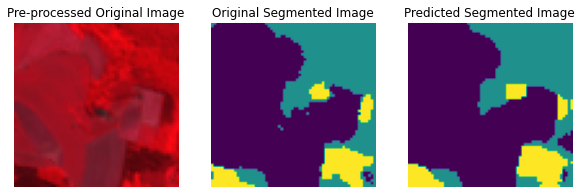

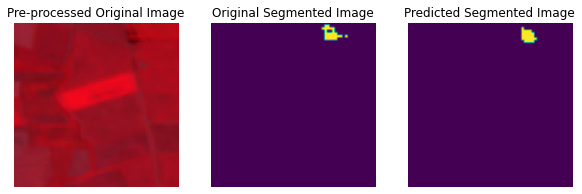

In [340]:
print('Visualizing Predictions on Multispectral Images')
plot_img(train_loader, unet,2)

## Training on RGB Images

In [230]:
unet_rgb = UNET(3,3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_rgb.parameters(), lr=0.01)
rgb_train_loss, rgb_valid_loss = train(unet_rgb, train_loader_rgb, val_loader_rgb, loss_fn, optimizer, acc_metric, epochs = 10)

Epoch 0/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Training


Epoch 0/9: 100%|███████████████████████████████████████| 228/228 [01:00<00:00,  3.77batch/s, accuracy=68.1, loss=0.696]


Epoch 0 Loss: 0.5762 Acc: 0.7680667638778687
Validation Step


Epoch 1/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 1.055510401725769  Validation Acc: 0.5603439211845398


Epoch 1/9: 100%|█████████████████████████████████████████| 228/228 [01:10<00:00,  3.24batch/s, accuracy=72, loss=0.751]


Epoch 1 Loss: 0.4907 Acc: 0.8017195463180542
Validation Step


Epoch 2/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.9130023121833801  Validation Acc: 0.6362751126289368


Epoch 2/9: 100%|███████████████████████████████████████| 228/228 [01:11<00:00,  3.18batch/s, accuracy=71.9, loss=0.664]


Epoch 2 Loss: 0.4595 Acc: 0.8161349892616272
Validation Step


Epoch 3/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7761260271072388  Validation Acc: 0.6761490106582642


Epoch 3/9: 100%|███████████████████████████████████████| 228/228 [01:12<00:00,  3.14batch/s, accuracy=78.9, loss=0.497]


Epoch 3 Loss: 0.4218 Acc: 0.8298962712287903
Validation Step


Epoch 4/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.887299120426178  Validation Acc: 0.6504378914833069


Epoch 4/9: 100%|█████████████████████████████████████████| 228/228 [01:14<00:00,  3.06batch/s, accuracy=83, loss=0.436]


Epoch 4 Loss: 0.4031 Acc: 0.837601900100708
Validation Step


Epoch 5/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7431962490081787  Validation Acc: 0.7000262141227722


Epoch 5/9: 100%|████████████████████████████████████████| 228/228 [01:11<00:00,  3.18batch/s, accuracy=78.8, loss=0.53]


Epoch 5 Loss: 0.3962 Acc: 0.8390187621116638
Validation Step


Epoch 6/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.8129066824913025  Validation Acc: 0.6707403063774109


Epoch 6/9: 100%|███████████████████████████████████████| 228/228 [01:13<00:00,  3.12batch/s, accuracy=84.9, loss=0.375]


Epoch 6 Loss: 0.3790 Acc: 0.8466102480888367
Validation Step


Epoch 7/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.746638834476471  Validation Acc: 0.6989660263061523


Epoch 7/9: 100%|███████████████████████████████████████| 228/228 [01:14<00:00,  3.06batch/s, accuracy=85.5, loss=0.407]


Epoch 7 Loss: 0.3687 Acc: 0.8515033721923828
Validation Step


Epoch 8/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.789777934551239  Validation Acc: 0.6920720934867859


Epoch 8/9: 100%|███████████████████████████████████████| 228/228 [01:13<00:00,  3.09batch/s, accuracy=84.1, loss=0.395]


Epoch 8 Loss: 0.3639 Acc: 0.853964626789093
Validation Step


Epoch 9/9:   0%|                                                                            | 0/228 [00:00<?, ?batch/s]

Validation Loss: 0.7476515769958496  Validation Acc: 0.7084936499595642


Epoch 9/9: 100%|███████████████████████████████████████| 228/228 [01:43<00:00,  2.21batch/s, accuracy=87.1, loss=0.333]


Epoch 9 Loss: 0.3522 Acc: 0.8578691482543945
Validation Step
Validation Loss: 0.8238471150398254  Validation Acc: 0.6817914843559265
Training complete in 15m 1s


In [316]:
torch.save(unet_rgb, 'model_rgb_new.pth')

Visualizing Predictions on RGB Images


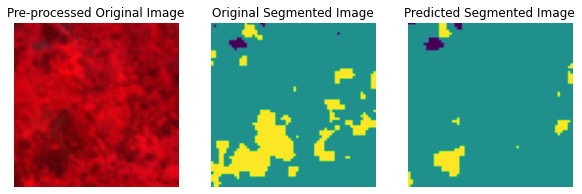

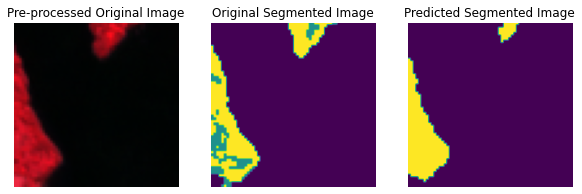

In [342]:
print('Visualizing Predictions on RGB Images')
plot_img(test_loader_rgb,unet_rgb,2)

In [320]:
def calc_acc(test_loader,model,loss_fn,acc_fn):
    test_loss = 0
    test_acc = 0

    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
        
    for test_data in test_loader:
        x_test = test_data['image'].to(device)
        y_test = test_data['label'].to(device)
        y_test = torch.squeeze(y_test,1)

        # forward pass
        y_hat = model(x_test)
        with torch.no_grad():
            # compute loss
            test_loss_temp = loss_fn(y_hat, y_test.long())
            test_acc_temp = acc_fn(y_hat, y_test)

            test_loss += test_loss_temp
            test_acc += test_acc_temp

    test_loss = test_loss/len(test_loader)
    test_acc = test_acc/len(test_loader)
    return test_loss, test_acc


In [321]:
test_loss, test_acc = calc_acc(test_loader, unet, loss_fn, acc_metric)
test_loss_rgb, test_acc_rgb = calc_acc(test_loader_rgb, unet_rgb, loss_fn, acc_metric)

In [322]:
print('Testing on RGB Images')
print('='*60)
print('Test loss : {}, Test accuracy : {:.2%}'.format(test_loss,test_acc))
print('\n')
print('Testing on Multispectral Images')
print('='*60)
print('Test loss : {}, Test accuracy : {:.2%}'.format(test_loss_rgb,test_acc_rgb))

Testing on RGB Images
Test loss : 0.4054985046386719, Test accuracy : 84.48%


Testing on Multispectral Images
Test loss : 0.4564289450645447, Test accuracy : 81.41%
